# Semi_defect_finder
반도체 공정/계측 데이터 기반 **결함 여부(불량/정상)** 이진 분류 모델 구축 노트북

- EDA → 전처리 → AutoML 모델링(A/B) → 평가 → 해석 → 운영(저장/스키마/드리프트)
- **시나리오 A**: `Etch_Depth` 포함(사후 판정 성격 가능)
- **시나리오 B**: `Etch_Depth` 제외(공정 조건+장비 상태 기반 사전/중간 판정)

> 요구사항에 따라 `Process_ID`, `Timestamp`는 **피처에서 제거**합니다(분할에만 필요하면 time-aware 옵션으로 사용).

[데이터]
| 컬럼명 | 데이터 타입 (예시) | 설명 | EDA 분석 포인트 |
| --- | --- | --- | --- |
| **Process_ID** | String | 공정 작업 고유 ID | 중복 데이터 확인 및 작업 단위 식별 |
| **Timestamp** | DateTime | 데이터 기록 시각 | 시간 흐름에 따른 공정 안정성 및 트렌드 분석 |
| **Tool_Type** | Categorical | 공정 설비 종류 (Lithography 등) | 설비별 불량률 차이 분석 |
| **Wafer_ID** | String | 웨이퍼 고유 식별 번호 | 특정 웨이퍼 로트(Lot)의 문제 여부 확인 |
| **Chamber_Temperature** | Float | 챔버 내부 온도 | 온도와 결함 간의 상관관계(상하한 임계치) |
| **Gas_Flow_Rate** | Float | 주입 가스 유량 | 가스 공급 안정성이 품질에 미치는 영향 |
| **RF_Power** | Float | 무선 주파수 전력 강도 | 에너지 세기와 식각/증착 품질의 관계 |
| **Etch_Depth** | Float | 식각(Etching) 깊이 | 목표 깊이 대비 편차 분석 |
| **Rotation_Speed** | Float | 장비/웨이퍼 회전 속도(RPM) | 회전 균일도와 코팅/식각 균일도 관계 |
| **Vacuum_Pressure** | Float | 챔버 내 진공 압력 | 압력 변화에 따른 파티클 발생 및 공정 오류 |
| **Stage_Alignment_Error** | Float | 스테이지 정렬 오차 | 정밀도 오류와 결함(Defect) 간의 상관성 |
| **Vibration_Level** | Float | 설비 미세 진동 수치 | 진동이 공정 정밀도에 미치는 영향 |
| **UV_Exposure_Intensity** | Float | UV 노광 강도 | 노광량 부족/과다에 따른 패턴 결함 분석 |
| **Particle_Count** | Integer | 미세 먼지(파티클) 개수 | 환경 오염도와 결함 여부의 직접적 연관성 |
| **Defect** | Binary (0, 1) | 결함 발생 여부 (Target) | 분류 모델의 종속 변수 (0: 정상, 1: 불량) |
| **Join_Status** | Categorical | 최종 공정 통과 상태 | 최종 판정 결과 (Joining: 합격, Non-Joining: 불량) |

In [2]:
# =========================================
# 0) CONFIG (여기만 바꿔 끼우면 됩니다)
# =========================================
CONFIG = {
    # 데이터
    "csv_path": "data/semiconductor_quality_control.csv",

    # 타깃 후보 (우선순위대로 탐색)
    "target_candidates": ["Defect"],
    
    # 공정(설비) 분리 기준 컬럼
    "tool_type_candidates": ["Tool_Type", "tool_type"],

    # Join_Status를 타깃으로 쓰고 싶다면 True로 (Defect와 중복/누수 확인 로직 포함)
    "use_join_status_as_target": False,
    "join_status_col_candidates": ["Join_Status"],
    "join_status_positive_values": ["Non-Joining", "FAIL", "Fail", "NG", "Bad", "Defect", "1"],  # 필요시 수정

    # 누수 위험 컬럼/ID류/시간류 (피처에서 제거)
    "drop_cols_always": ["Process_ID", "Timestamp"],

    # Etch_Depth 후보 (A/B 시나리오 분기)
    "etch_depth_candidates": ["Etch_Depth"],

    # 공정(설비) 분리 기준 컬럼
    "tool_type_candidates": ["Tool_Type", "tool_type"],

    # 그룹 분할 우선순위: wafer/lot 단위
    "group_candidates": ["Wafer_ID", "wafer_id", "Lot_ID", "lot_id", "die_id", "Die_ID"],

    # 시간 분할 컬럼 후보 (분할에만 사용)
    "time_candidates": ["Timestamp", "timestamp", "DateTime", "datetime", "time", "Time"],

    # 모델/검증
    "random_state": 42,
    "test_size": 0.2,
    "cv_splits": 5,
    "n_iter_search": 30,
    "scoring_primary": "average_precision",  # PR-AUC(AP)
    "precision_constraint": 0.90,            # threshold 선택 시 precision 최소
    "calibration": None,                     # None / "sigmoid" / "isotonic"

    # 전처리 옵션
    "use_iterative_imputer": False,          # True로 바꾸면 IterativeImputer 사용
    "winsorize_limits": (0.01, 0.01),        # 상하 1% winsorization
    "use_isolation_forest": False,           # 선택 옵션(훈련셋 필터링 원칙)

    # 출력/저장
    "model_output_dir": "./artifacts",
    "model_name_prefix": "semi_defect_model",
}



In [41]:
# =========================================
# 1) Imports (preprocess & modeling)
# =========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from dataclasses import dataclass
from typing import List, Optional

from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator, TransformerMixin



In [4]:
# =========================================
# 2) Load data & basic checks
# =========================================

df = pd.read_csv(CONFIG["csv_path"])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

target_col = "Defect"
tool_col = "Tool_Type"


print("Target col:", target_col)
print("Tool_Type col:", tool_col)

# 결측률 상위 확인
print("Missing ratio (top 10):")
print(df.isna().mean().sort_values(ascending=False).head(16))


Shape: (4219, 16)
Columns: ['Process_ID', 'Timestamp', 'Tool_Type', 'Wafer_ID', 'Chamber_Temperature', 'Gas_Flow_Rate', 'RF_Power', 'Etch_Depth', 'Rotation_Speed', 'Vacuum_Pressure', 'Stage_Alignment_Error', 'Vibration_Level', 'UV_Exposure_Intensity', 'Particle_Count', 'Defect', 'Join_Status']
Target col: Defect
Tool_Type col: Tool_Type
Missing ratio (top 10):
Process_ID               0.0
Timestamp                0.0
Tool_Type                0.0
Wafer_ID                 0.0
Chamber_Temperature      0.0
Gas_Flow_Rate            0.0
RF_Power                 0.0
Etch_Depth               0.0
Rotation_Speed           0.0
Vacuum_Pressure          0.0
Stage_Alignment_Error    0.0
Vibration_Level          0.0
UV_Exposure_Intensity    0.0
Particle_Count           0.0
Defect                   0.0
Join_Status              0.0
dtype: float64


In [5]:
# =========================================
# 3) Tool_Type별 분포 및 불량률 확인
# =========================================

tool_summary = (df.groupby(tool_col)[target_col].agg(count='size', defect_rate='mean').sort_values('count', ascending=False))
print(tool_summary)

# 샘플이 너무 작은 Tool_Type 경고
min_n = 100
small_tools = tool_summary[tool_summary['count'] < min_n]
if not small_tools.empty:
    print("\n[주의] 샘플 수가 적은 Tool_Type:")
    print(small_tools)


             count  defect_rate
Tool_Type                      
Etching       1418     0.143159
Deposition    1416     0.153955
Lithography   1385     0.141516


In [6]:
# =========================================
# Defect vs Join_Status 일치율 계산 (원본 다시 로드)
# =========================================
df_raw = pd.read_csv(CONFIG["csv_path"])

js_bin = df_raw["Join_Status"].astype(str).str.strip().str.lower().map(
    {"non-joining": 1, "joining": 0}
)

valid = js_bin.notna()
agree = (df_raw.loc[valid, "Defect"].astype(int).values == js_bin.loc[valid].values).mean()

print(f"Agreement rate: {agree:.4f}")


Agreement rate: 1.0000


In [7]:
# =========================================
# 3.5) 컬럼 제거 (원본 분리 전에)
# =========================================

cols_to_drop = [c for c in ["Process_ID", "Timestamp","Join_Status",] if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print("Dropped columns:", cols_to_drop)
else:
    print("No Process_ID/Timestamp/Join_Status/ columns found.")


Dropped columns: ['Process_ID', 'Timestamp', 'Join_Status']


In [8]:
df.head()

,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
0,Lithography,WAF58120,74.077728,56.527432,324.281923,554.358076,1397.936121,0.549974,2.147302,0.009007,128.419361,118,0
1,Deposition,WAF31094,74.341499,39.350802,364.527083,493.382895,1433.488274,0.407351,2.970405,0.007927,109.449848,525,0
2,Deposition,WAF44062,74.626094,38.181393,314.257182,589.544476,1311.345430,0.480282,1.310555,0.008856,161.172686,729,0
3,Etching,WAF46726,79.467364,47.569284,301.464082,488.986118,1342.928970,0.492940,1.564590,0.009416,133.259454,178,0
4,Lithography,WAF39030,76.221205,59.152873,289.702098,458.012763,1785.025252,0.557101,2.338089,0.009590,117.129348,514,1


In [9]:
# =========================================
# 4) Tool_Type별 원본 데이터 분리 (복붙용)
# =========================================

# 1) Tool_Type 컬럼 찾기 (대소문자/변형 대응)
tool_candidates = ["Tool_Type", "tool_type", "TOOL_TYPE", "tooltype", "ToolType"]
tool_col = None
for c in tool_candidates:
    if c in df.columns:
        tool_col = c
        break

if tool_col is None:
    raise KeyError(f"Tool_Type 컬럼을 찾지 못했습니다. 현재 컬럼: {df.columns.tolist()}")

# 2) 문자열 정규화
df[tool_col] = df[tool_col].astype(str).str.strip().str.lower()

# 3) 리쏘/에칭/데포로 분리
df_litho = df[df[tool_col] == "lithography"].copy()
df_etch  = df[df[tool_col] == "etching"].copy()
df_depo  = df[df[tool_col] == "deposition"].copy()

print("lithography:", df_litho.shape)
print("etching:", df_etch.shape)
print("deposition:", df_depo.shape)

display(df_litho.head())
display(df_etch.head())
display(df_depo.head())

lithography: (1385, 13)
etching: (1418, 13)
deposition: (1416, 13)


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
0,lithography,WAF58120,74.077728,56.527432,324.281923,554.358076,1397.936121,0.549974,2.147302,0.009007,128.419361,118,0
4,lithography,WAF39030,76.221205,59.152873,289.702098,458.012763,1785.025252,0.557101,2.338089,0.009590,117.129348,514,1
5,lithography,WAF77484,72.406000,52.230743,286.161543,495.476249,1363.693532,0.432724,3.133414,0.009360,139.292220,513,0
10,lithography,WAF89845,74.777007,46.819801,279.926539,563.066838,2071.380657,0.392305,0.197213,0.011887,108.978847,298,0
11,lithography,WAF49453,85.666323,69.293533,285.921599,511.264062,1360.282764,0.529752,2.423294,0.018540,118.536442,796,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
3,etching,WAF46726,79.467364,47.569284,301.464082,488.986118,1342.928970,0.492940,1.564590,0.009416,133.259454,178,0
6,etching,WAF93190,74.031582,34.524690,325.060209,502.503207,1860.943159,0.557813,1.858771,0.008604,115.391153,445,1
8,etching,WAF90138,75.574564,31.129065,222.565983,485.660598,1037.924539,0.494761,2.842610,0.015432,123.818165,970,0
9,etching,WAF34798,89.370413,74.383993,221.146587,618.681459,1342.417979,0.446146,1.823190,0.015130,154.059938,787,0
12,etching,WAF54023,69.662915,50.122469,271.631064,403.201004,1383.952796,0.438330,1.827425,0.003506,122.514252,109,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
1,deposition,WAF31094,74.341499,39.350802,364.527083,493.382895,1433.488274,0.407351,2.970405,0.007927,109.449848,525,0
2,deposition,WAF44062,74.626094,38.181393,314.257182,589.544476,1311.345430,0.480282,1.310555,0.008856,161.172686,729,0
7,deposition,WAF48082,74.972943,34.676196,219.520268,564.177109,1250.188972,0.570861,0.037162,0.009037,136.742235,653,0
23,deposition,WAF66820,69.510619,57.636426,315.717919,611.399196,1152.332112,0.514648,2.254649,0.001079,95.330599,112,0
24,deposition,WAF90800,76.939137,44.227121,355.982551,505.679897,1359.628708,0.477417,2.752692,0.019110,116.621626,605,0


# 공정별 컬럼 정리

## 1) Lithography 공정
### 유지 컬럼 (합법 컬럼)
- Tool_Type: Lithography 구분
- Wafer_ID: 웨이퍼 단위 분석
- UV_Exposure_Intensity: 리쏘 핵심 제어 노브
- Stage_Alignment_Error: Overlay/패턴 정밀도 직결
- Chamber_Temperature: 포토 공정 안정성
- Rotation_Speed: 스핀 코팅 균일도
- Vibration_Level: 정렬·포커스 불안정 요인
- Particle_Count: 패턴 결함 직접 원인
- Defect: 타깃 변수

### 제거 컬럼 (해석 시)
- Etch_Depth: 에칭 결과 변수 (downstream)
- RF_Power: 에칭 공정 제어 변수
- Vacuum_Pressure: 에칭 공정 제어 변수
- Gas_Flow_Rate: 증착/에칭 공정 변수
- Join_Status: Defect와 중복되는 사후 판정

---

## 2) Etching 공정
### 유지 컬럼 (합법 컬럼)
- Tool_Type: Etching 구분
- Wafer_ID: 웨이퍼 단위 추적
- RF_Power: 에칭 핵심 제어 노브
- Vacuum_Pressure: 플라즈마 상태 결정
- Gas_Flow_Rate: 식각 균일도 영향
- Chamber_Temperature: 반응 속도 영향
- Etch_Depth: 에칭 직접 결과
- Stage_Alignment_Error: 패턴 왜곡 영향
- Vibration_Level: 플라즈마 안정성
- Particle_Count: 식각 결함 직접 요인
- Defect: 타깃 변수

### 제거 컬럼 (해석 시)
- UV_Exposure_Intensity: 리쏘 공정 전용 변수
- Rotation_Speed: 스핀/코팅 공정 전용
- Join_Status: 사후 판정

---

## 3) Deposition 공정
### 유지 컬럼 (합법 컬럼)
- Tool_Type: Deposition 구분
- Wafer_ID: 웨이퍼 단위 추적
- Gas_Flow_Rate: 증착 공정 핵심 변수
- Chamber_Temperature: 반응 속도 영향
- Vacuum_Pressure: 막질/플라즈마 상태 영향
- Vibration_Level: 공정 안정성 영향
- Particle_Count: 막질 결함 직접 요인
- Defect: 타깃 변수

### 제거 컬럼 (해석 시)
- Etch_Depth: 식각 결과 변수
- RF_Power: 에칭 전용
- UV_Exposure_Intensity: 리쏘 전용
- Stage_Alignment_Error: 리쏘 중심 변수
- Join_Status: 사후 판정


In [10]:
# =========================================
#  Stage_Alignment, Vibration_Level 절대값 변환
# =========================================

df["Stage_Alignment_Error"] = df["Stage_Alignment_Error"].abs()
df["Vibration_Level"] = df["Vibration_Level"].abs()


In [11]:
# 공정별 제거 컬럼 정의
drop_litho = [
    "Etch_Depth", "RF_Power", "Vacuum_Pressure", "Gas_Flow_Rate"
]

drop_etch = [
    "UV_Exposure_Intensity", "Rotation_Speed"
]

# Deposition 제거 컬럼 (이미지 기준, 확정 필요)
drop_depo = [
    "Etch_Depth", "RF_Power", "UV_Exposure_Intensity", "Stage_Alignment_Error"
]

# 컬럼이 존재하는 것만 안전하게 제거
def drop_cols_safe(df_part, drop_list):
    cols = [c for c in drop_list if c in df_part.columns]
    return df_part.drop(columns=cols)

df_litho_clean = drop_cols_safe(df_litho, drop_litho)
df_etch_clean  = drop_cols_safe(df_etch, drop_etch)
df_depo_clean  = drop_cols_safe(df_depo, drop_depo)

display(df_litho_clean.head())
display(df_etch_clean.head())
display(df_depo_clean.head())

,Tool_Type,Wafer_ID,Chamber_Temperature,Rotation_Speed,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
0,lithography,WAF58120,74.077728,1397.936121,2.147302,0.009007,128.419361,118,0
4,lithography,WAF39030,76.221205,1785.025252,2.338089,0.009590,117.129348,514,1
5,lithography,WAF77484,72.406000,1363.693532,3.133414,0.009360,139.292220,513,0
10,lithography,WAF89845,74.777007,2071.380657,0.197213,0.011887,108.978847,298,0
11,lithography,WAF49453,85.666323,1360.282764,2.423294,0.018540,118.536442,796,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,Particle_Count,Defect
3,etching,WAF46726,79.467364,47.569284,301.464082,488.986118,0.492940,1.564590,0.009416,178,0
6,etching,WAF93190,74.031582,34.524690,325.060209,502.503207,0.557813,1.858771,0.008604,445,1
8,etching,WAF90138,75.574564,31.129065,222.565983,485.660598,0.494761,2.842610,0.015432,970,0
9,etching,WAF34798,89.370413,74.383993,221.146587,618.681459,0.446146,1.823190,0.015130,787,0
12,etching,WAF54023,69.662915,50.122469,271.631064,403.201004,0.438330,1.827425,0.003506,109,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,Rotation_Speed,Vacuum_Pressure,Vibration_Level,Particle_Count,Defect
1,deposition,WAF31094,74.341499,39.350802,1433.488274,0.407351,0.007927,525,0
2,deposition,WAF44062,74.626094,38.181393,1311.345430,0.480282,0.008856,729,0
7,deposition,WAF48082,74.972943,34.676196,1250.188972,0.570861,0.009037,653,0
23,deposition,WAF66820,69.510619,57.636426,1152.332112,0.514648,0.001079,112,0
24,deposition,WAF90800,76.939137,44.227121,1359.628708,0.477417,0.019110,605,0


In [12]:
# =========================================
# EDA 기본 (공정별)
# =========================================

def basic_eda(df_in, name=""):
    print(f"\n==================== {name} ====================")
    print("Shape:", df_in.shape)


    if "Defect" in df_in.columns:
        print("\nDefect rate:")
        print(df_in["Defect"].value_counts(normalize=True))
    else:
        print("\nDefect column not found.")

    num_cols = df_in.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\nNumeric summary:")
        display(df_in[num_cols].describe())

        if "Defect" in num_cols:
            corr = df_in[num_cols].corr()["Defect"].sort_values(ascending=False)
            print("\nCorrelation with Defect:")
            print(corr)
        else:
            print("\nDefect not numeric for correlation.")
    else:
        print("\nNo numeric columns.")

    if "Tool_Type" in df_in.columns:
        tool_summary = df_in.groupby("Tool_Type")["Defect"].agg(count="size", defect_rate="mean")
        print("\nTool_Type summary:")
        print(tool_summary)

# 공정별 EDA 실행
basic_eda(df_litho_clean, "Lithography")
basic_eda(df_etch_clean, "Etching")
basic_eda(df_depo_clean, "Deposition")



==================== Lithography ====================
Shape: (1385, 9)

Defect rate:
Defect
0    0.858484
1    0.141516
Name: proportion, dtype: float64

Numeric summary:


,Chamber_Temperature,Rotation_Speed,Stage_Alignment_Error,Vibration_Level,UV_Exposure_Intensity,Particle_Count,Defect
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,74.919829,1508.437144,1.981132,0.010269,120.012080,556.756679,0.141516
std,4.999050,203.966023,0.823599,0.005005,14.980429,259.937716,0.348679
min,55.718123,859.588353,-0.403722,-0.004957,76.159262,101.000000,0.000000
25%,71.502552,1381.241094,1.444809,0.006876,109.682409,338.000000,0.000000
50%,74.926261,1510.001455,2.001389,0.010260,119.711098,562.000000,0.000000
75%,78.421350,1643.569406,2.524932,0.013574,130.030518,786.000000,0.000000
max,97.395421,2199.022643,4.460529,0.029149,170.990733,999.000000,1.000000



Correlation with Defect:
Defect                   1.000000
Stage_Alignment_Error    0.030234
Vibration_Level          0.023928
Rotation_Speed          -0.003345
Chamber_Temperature     -0.009516
UV_Exposure_Intensity   -0.013332
Particle_Count          -0.029969
Name: Defect, dtype: float64

Tool_Type summary:
             count  defect_rate
Tool_Type                      
lithography   1385     0.141516

==================== Etching ====================
Shape: (1418, 11)

Defect rate:
Defect
0    0.856841
1    0.143159
Name: proportion, dtype: float64

Numeric summary:


,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,Particle_Count,Defect
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000
mean,75.274331,50.064445,301.384054,497.551161,0.503724,2.026284,0.009903,552.079690,0.143159
std,4.981890,9.878395,50.778250,100.360447,0.049795,0.817644,0.004965,261.762737,0.350359
min,57.524774,20.583715,128.617224,173.469872,0.352028,-0.780030,-0.005201,100.000000,0.000000
25%,71.977503,43.483935,265.915663,430.602775,0.470178,1.483207,0.006453,321.250000,0.000000
50%,75.220051,49.847879,301.591810,498.260823,0.503915,2.027311,0.009827,558.000000,0.000000
75%,78.605266,56.830203,337.428943,564.035443,0.536958,2.585394,0.013211,777.750000,0.000000
max,94.711655,83.352682,476.826583,795.119660,0.651884,4.537797,0.025431,999.000000,1.000000



Correlation with Defect:
Defect                   1.000000
Chamber_Temperature      0.024101
Vibration_Level          0.002557
Particle_Count           0.000999
Etch_Depth              -0.001655
Vacuum_Pressure         -0.010573
Gas_Flow_Rate           -0.020499
RF_Power                -0.025616
Stage_Alignment_Error   -0.043209
Name: Defect, dtype: float64

Tool_Type summary:
           count  defect_rate
Tool_Type                    
etching     1418     0.143159

==================== Deposition ====================
Shape: (1416, 9)

Defect rate:
Defect
0    0.846045
1    0.153955
Name: proportion, dtype: float64

Numeric summary:


,Chamber_Temperature,Gas_Flow_Rate,Rotation_Speed,Vacuum_Pressure,Vibration_Level,Particle_Count,Defect
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,75.033573,50.089610,1504.074478,0.498114,0.010101,558.759181,0.153955
std,5.021333,10.248675,201.162169,0.050159,0.004861,264.309278,0.361033
min,58.460500,15.466459,862.054037,0.347691,-0.005174,100.000000,0.000000
25%,71.658320,42.677751,1365.290790,0.466431,0.006744,327.000000,0.000000
50%,75.042640,50.326279,1506.134578,0.498164,0.010183,561.000000,0.000000
75%,78.368828,57.449578,1637.696263,0.529928,0.013412,790.250000,0.000000
max,90.191408,86.024150,2194.309895,0.688008,0.024045,999.000000,1.000000



Correlation with Defect:
Defect                 1.000000
Chamber_Temperature    0.036854
Gas_Flow_Rate          0.014564
Vibration_Level        0.004755
Vacuum_Pressure        0.002246
Rotation_Speed        -0.021322
Particle_Count        -0.055586
Name: Defect, dtype: float64

Tool_Type summary:
            count  defect_rate
Tool_Type                     
deposition   1416     0.153955


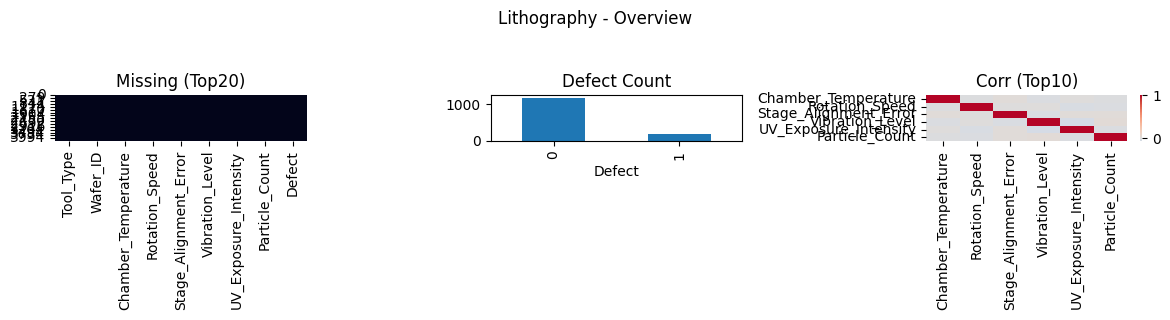

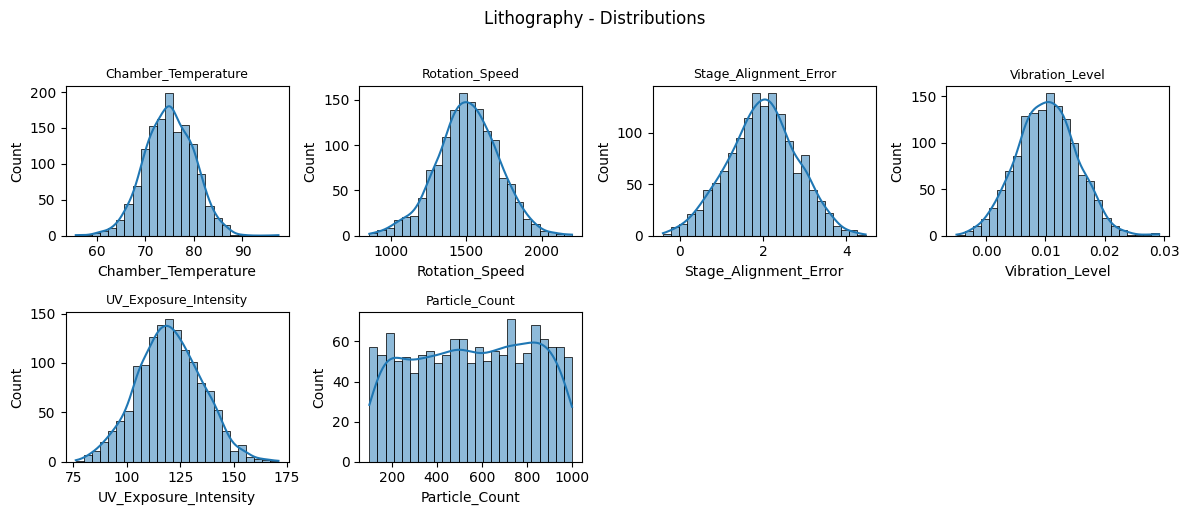

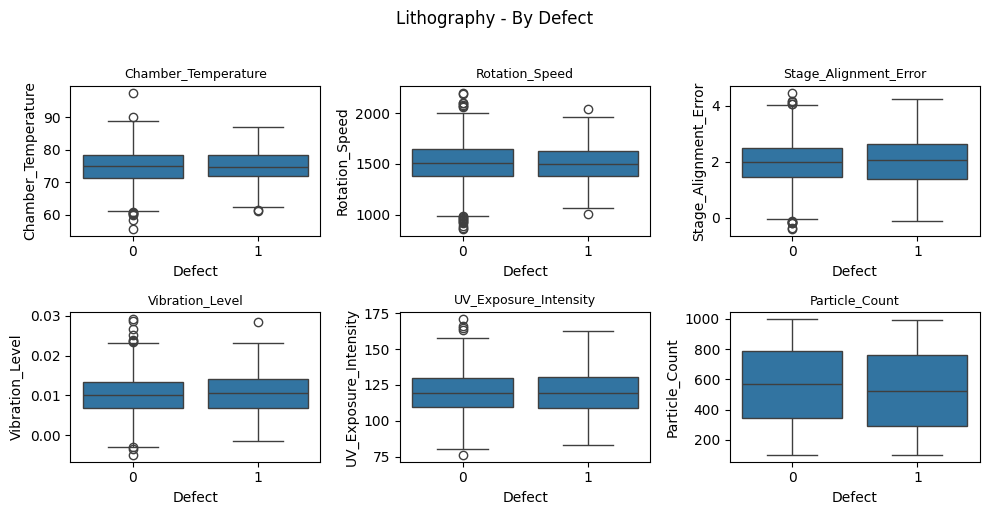

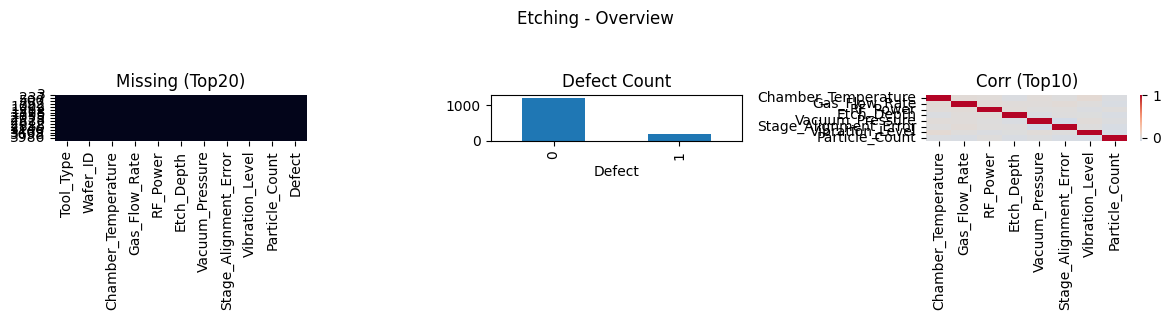

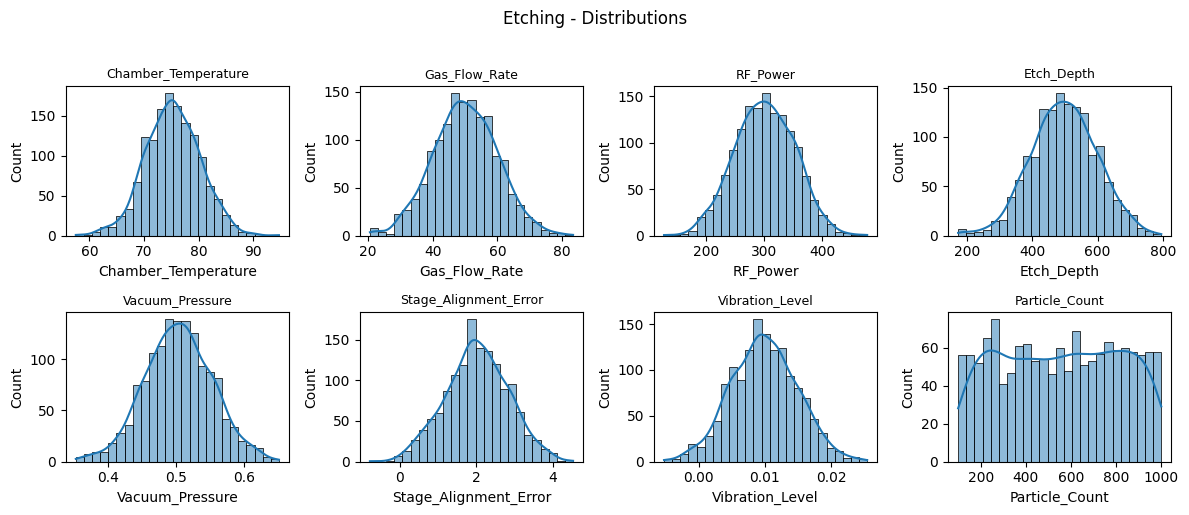

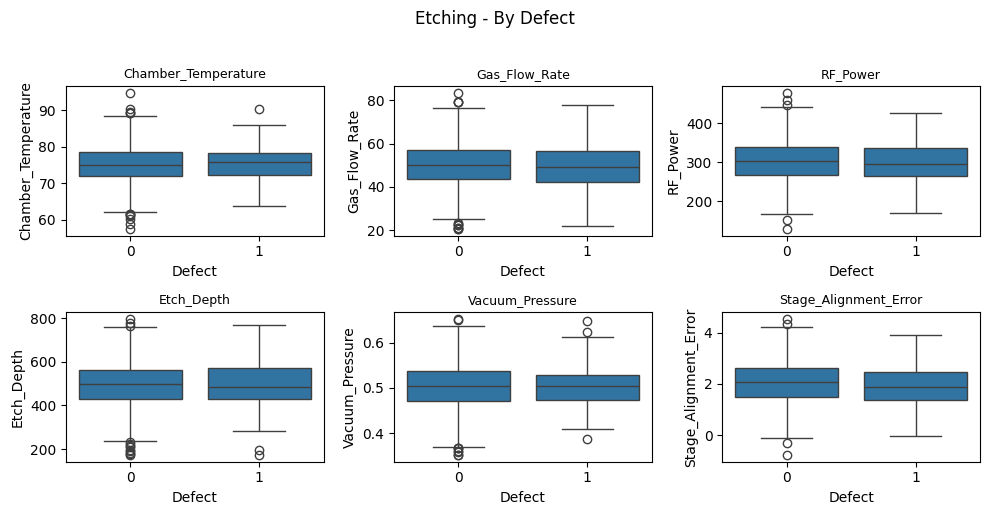

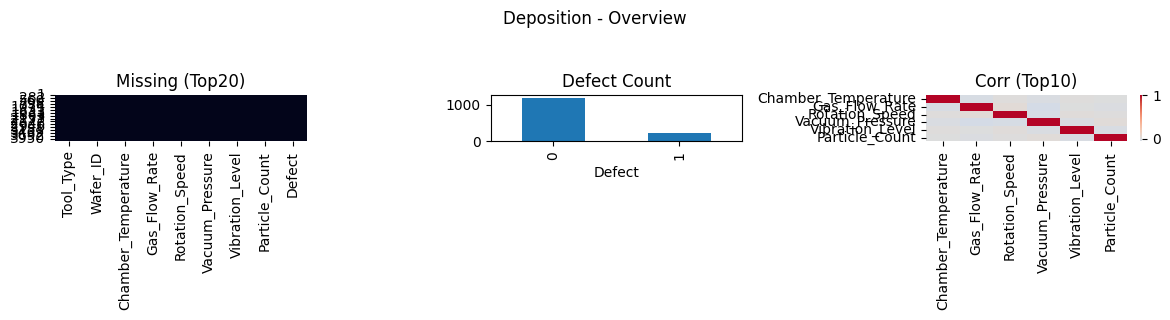

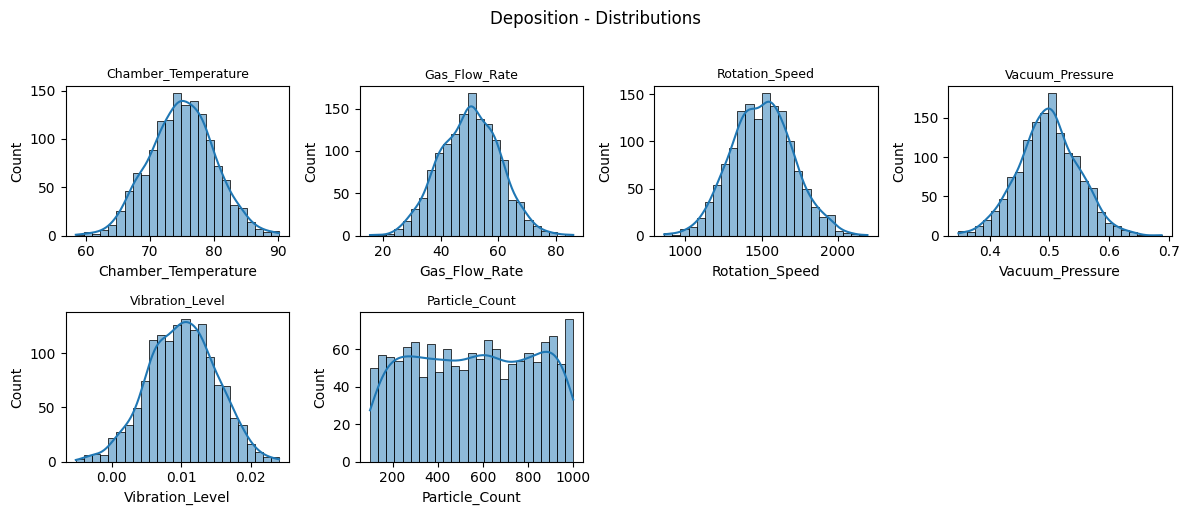

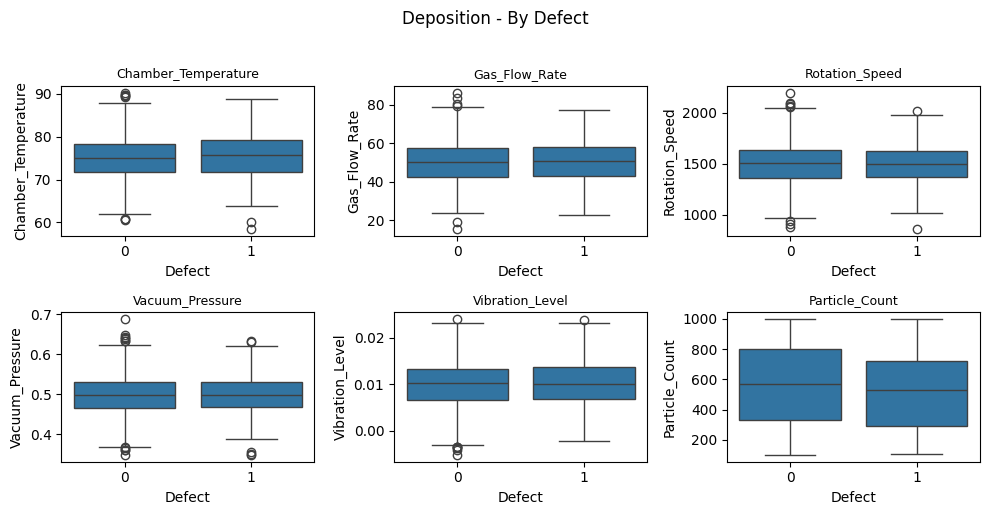

In [13]:
def eda_plots_grid(df_in, name=""):
    num_cols = df_in.select_dtypes(include=[np.number]).columns
    num_cols = [c for c in num_cols if c != "Defect"]

    # 1) 결측치 히트맵 + 타깃 분포 + 상관계수 (한 줄)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    fig.suptitle(f"{name} - Overview", y=1.05)

    # Missing heatmap (상위 20)
    missing = df_in.isna().mean().sort_values(ascending=False)
    top_cols = missing.head(20).index
    sns.heatmap(df_in[top_cols].isna(), cbar=False, ax=axes[0])
    axes[0].set_title("Missing (Top20)")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")

    # Defect 분포
    if "Defect" in df_in.columns:
        df_in["Defect"].value_counts().plot(kind="bar", ax=axes[1])
        axes[1].set_title("Defect Count")
    else:
        axes[1].text(0.5, 0.5, "No Defect", ha="center", va="center")

    # 상관계수 히트맵 (수치형 10개)
    if len(num_cols) > 1:
        top_num = num_cols[:10]
        corr = df_in[top_num].corr()
        sns.heatmap(corr, cmap="coolwarm", center=0, ax=axes[2])
        axes[2].set_title("Corr (Top10)")
    else:
        axes[2].text(0.5, 0.5, "No numeric", ha="center", va="center")

    plt.tight_layout()
    plt.show()

    # 2) 수치형 분포 (2행 x 4열)
    show_cols = num_cols[:8]
    if len(show_cols) > 0:
        fig, axes = plt.subplots(2, 4, figsize=(12, 5))
        axes = axes.flatten()
        fig.suptitle(f"{name} - Distributions", y=1.02)

        for i, c in enumerate(show_cols):
            sns.histplot(df_in[c], bins=25, kde=True, ax=axes[i])
            axes[i].set_title(c, fontsize=9)

        for j in range(len(show_cols), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    # 3) Defect 기준 박스플롯 (2행 x 3열)
    if "Defect" in df_in.columns and len(num_cols) > 0:
        show_cols = num_cols[:6]
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))
        axes = axes.flatten()
        fig.suptitle(f"{name} - By Defect", y=1.02)

        for i, c in enumerate(show_cols):
            sns.boxplot(x="Defect", y=c, data=df_in, ax=axes[i])
            axes[i].set_title(c, fontsize=9)

        for j in range(len(show_cols), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

# 공정별 실행
eda_plots_grid(df_litho_clean, "Lithography")
eda_plots_grid(df_etch_clean, "Etching")
eda_plots_grid(df_depo_clean, "Deposition")


Lithography                   Etching                \
                              mean           var        mean           var   
Chamber_Temperature      74.919829     24.990501   75.274331     24.819225   
Rotation_Speed         1508.437144  41602.138640         NaN           NaN   
Stage_Alignment_Error     1.981132      0.678316    2.026284      0.668542   
Vibration_Level           0.010269      0.000025    0.009903      0.000025   
UV_Exposure_Intensity   120.012080    224.413246         NaN           NaN   
Particle_Count          556.756679  67567.616330  552.079690  68519.730413   
Gas_Flow_Rate                  NaN           NaN   50.064445     97.582682   
RF_Power                       NaN           NaN  301.384054   2578.430664   
Vacuum_Pressure                NaN           NaN    0.503724      0.002480   
Etch_Depth                     NaN           NaN  497.551161  10072.219363   

                        Deposition                
                              mean           var  
Chamber_Temperature      75.033573     25.213788  
Rotation_Speed         1504.074478  40466.218092  
Stage_Alignment_Error          NaN           NaN  
Vibration_Level           0.010101      0.000024  
UV_Exposure_Intensity          NaN           NaN  
Particle_Count          558.759181  69859.394262  
Gas_Flow_Rate            50.089610    105.035344  
RF_Power                       NaN           NaN  
Vacuum_Pressure           0.498114      0.002516  
Etch_Depth                     NaN           NaN

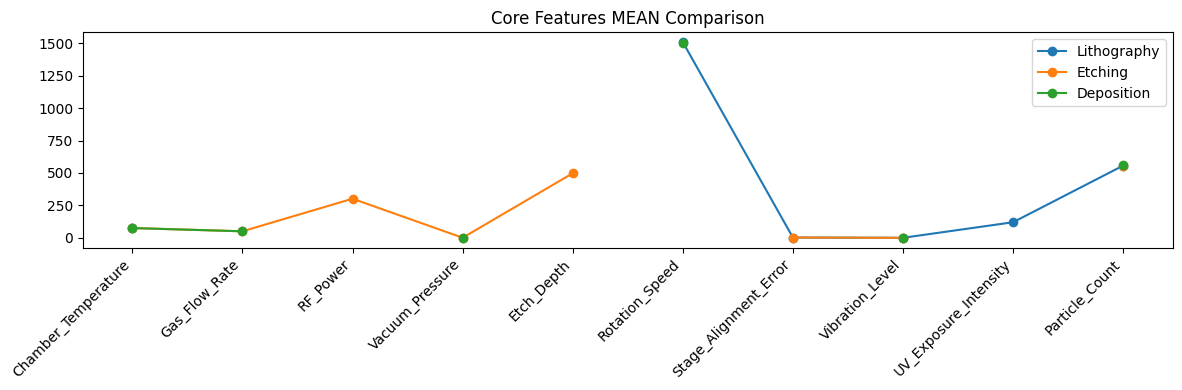

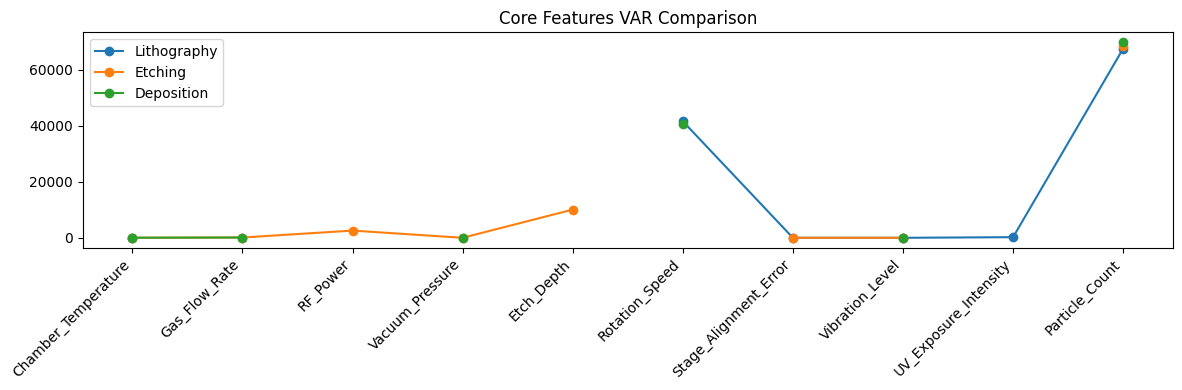

In [14]:
# =========================================
# 공정별 핵심 변수 평균/분산 비교
# =========================================

core_cols = [
    "Chamber_Temperature",
    "Gas_Flow_Rate",
    "RF_Power",
    "Vacuum_Pressure",
    "Etch_Depth",
    "Rotation_Speed",
    "Stage_Alignment_Error",
    "Vibration_Level",
    "UV_Exposure_Intensity",
    "Particle_Count",
]

def compare_mean_var(df_litho, df_etch, df_depo, cols):
    # 공정별 통계
    def stat_df(df_in, name):
        data = {}
        for c in cols:
            if c in df_in.columns:
                data[c] = {
                    "mean": df_in[c].mean(),
                    "var": df_in[c].var()
                }
        out = pd.DataFrame(data).T
        out.columns = pd.MultiIndex.from_product([[name], out.columns])
        return out

    litho_stat = stat_df(df_litho, "Lithography")
    etch_stat = stat_df(df_etch, "Etching")
    depo_stat = stat_df(df_depo, "Deposition")

    summary = pd.concat([litho_stat, etch_stat, depo_stat], axis=1)
    display(summary)

    # 시각화 (mean, var)
    for metric in ["mean", "var"]:
        plt.figure(figsize=(12, 4))
        for name, df_in in [("Lithography", df_litho), ("Etching", df_etch), ("Deposition", df_depo)]:
            vals = []
            for c in cols:
                vals.append(df_in[c].mean() if metric=="mean" and c in df_in.columns else
                            df_in[c].var() if metric=="var" and c in df_in.columns else
                            np.nan)
            plt.plot(cols, vals, marker="o", label=name)

        plt.title(f"Core Features {metric.upper()} Comparison")
        plt.xticks(rotation=45, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()

compare_mean_var(df_litho_clean, df_etch_clean, df_depo_clean, core_cols)


# 그룹 분할(GroupSplit) 코드 설명

## 목적
- 같은 웨이퍼/로트 데이터가 train/test에 섞이지 않도록 분리해 **데이터 누수**를 방지한다.
- 실제 운영 환경에서 “새 웨이퍼/로트”에 대해 평가하는 상황과 유사하게 만든다.

## 동작 흐름
1. `group_candidates`에서 실제 존재하는 그룹 컬럼(`Wafer_ID` 또는 `Lot_ID`)을 자동으로 찾는다.
2. `GroupShuffleSplit`으로 **그룹 단위**로 train/test를 나눈다.
3. 분할 후 train/test의 그룹이 겹치는지 검사하여 누수가 없는지 확인한다.

## 코드 구성 요소
- `get_group_col(df_in)`
  - 데이터프레임에 존재하는 그룹 컬럼을 자동 선택
  - 없으면 오류 발생
- `group_split(df_in, name="")`
  - `GroupShuffleSplit`으로 그룹 기준 분할
  - 분할 후 train/test 크기와 그룹 중복 수 출력

## 출력 결과
- `[공정명] group_col` : 분할 기준이 된 컬럼명
- `[공정명] train shape`, `test shape` : 분할된 데이터 크기
- `[공정명] 그룹 중복 수` : 누수 여부 확인 (0이 정상)


In [15]:
from sklearn.model_selection import GroupShuffleSplit

# =========================================
# GroupSplit (Wafer_ID 기준)
# =========================================
def group_split_wafer(df_in, name=""):
    if "Wafer_ID" not in df_in.columns:
        raise KeyError(f"[{name}] Wafer_ID 없음. 컬럼: {df_in.columns.tolist()}")

    X = df_in.drop(columns=["Defect"])
    y = df_in["Defect"]
    groups = df_in["Wafer_ID"]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train = X.iloc[train_idx].copy()
    X_test  = X.iloc[test_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_test  = y.iloc[test_idx].copy()

    # 분할 후 Wafer_ID 제거
    X_train = X_train.drop(columns=["Wafer_ID"])
    X_test  = X_test.drop(columns=["Wafer_ID"])

    # 그룹 중복 확인
    overlap = set(groups.iloc[train_idx]).intersection(set(groups.iloc[test_idx]))
    print(f"[{name}] 그룹 중복 수:", len(overlap))
    print(f"[{name}] train/test:", X_train.shape, X_test.shape)

    return X_train, X_test, y_train, y_test

# 공정별 적용 (Wafer_ID가 살아있는 df 사용)
Xl_tr, Xl_te, yl_tr, yl_te = group_split_wafer(df_litho, "Lithography")
Xe_tr, Xe_te, ye_tr, ye_te = group_split_wafer(df_etch, "Etching")
Xd_tr, Xd_te, yd_tr, yd_te = group_split_wafer(df_depo, "Deposition")


[Lithography] 그룹 중복 수: 0
[Lithography] train/test: (1107, 11) (278, 11)
[Etching] 그룹 중복 수: 0
[Etching] train/test: (1135, 11) (283, 11)
[Deposition] 그룹 중복 수: 0
[Deposition] train/test: (1130, 11) (286, 11)


# 변수쌍 위험 구간 랭킹 코드 설명

## 목적
- 변수쌍별로 **불량률이 가장 높은 구간**을 찾고  
  전체 평균 대비 **불량률 상승 배수(lift)**로 랭킹한다.

## 동작 흐름
1. 각 변수쌍을 분위수 bin으로 나눔  
2. bin 조합별 불량률과 샘플 수 계산  
3. 표본 수가 충분한 구간만 필터  
4. 불량률 상승 배수(lift)가 가장 높은 구간을 선택  
5. 변수쌍별로 최고 구간을 랭킹 정렬

## 출력 의미
- `best_lift`: 전체 평균 대비 불량률 배수  
- `count`: 해당 구간 표본 수  
- `x_bin`, `y_bin`: 최고 위험 구간의 실제 값 범위


In [66]:
def rank_pair_lift(df_in, pairs, target="Defect", bins=10, top_n=4, min_count=30):
    base_rate = df_in[target].mean()
    results = []

    for x, y in pairs:
        if x not in df_in.columns or y not in df_in.columns:
            continue

        df = df_in[[x, y, target]].dropna().copy()
        df["x_bin"] = pd.qcut(df[x], q=bins, duplicates="drop")
        df["y_bin"] = pd.qcut(df[y], q=bins, duplicates="drop")

        pivot_rate = df.pivot_table(values=target, index="y_bin", columns="x_bin", aggfunc="mean")
        pivot_cnt  = df.pivot_table(values=target, index="y_bin", columns="x_bin", aggfunc="count")

        lift = pivot_rate / base_rate

        lift_stack = lift.stack().reset_index()
        lift_stack.columns = ["y_bin", "x_bin", "lift"]

        cnt_stack = pivot_cnt.stack().reset_index()
        cnt_stack.columns = ["y_bin", "x_bin", "count"]

        merged = lift_stack.merge(cnt_stack, on=["y_bin", "x_bin"])
        merged = merged[merged["count"] >= min_count]

        if merged.empty:
            continue

        top_row = merged.sort_values("lift", ascending=False).iloc[0]

        results.append({
            "pair": f"{x} vs {y}",
            "best_lift": top_row["lift"],
            "count": int(top_row["count"]),
            "x_bin": str(top_row["x_bin"]),
            "y_bin": str(top_row["y_bin"])
        })

    return pd.DataFrame(results).sort_values("best_lift", ascending=False).head(top_n)


# 공정별 변수쌍
pairs_litho = [
    ("UV_Exposure_Intensity", "Stage_Alignment_Error"),
    ("Chamber_Temperature", "Rotation_Speed"),
    ("Particle_Count", "Vibration_Level"),
    ("UV_Exposure_Intensity", "Chamber_Temperature"),
]

pairs_etch = [
    ("RF_Power", "Vacuum_Pressure"),
    ("RF_Power", "Gas_Flow_Rate"),
    ("Etch_Depth", "RF_Power"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
]

pairs_depo = [
    ("Gas_Flow_Rate", "Chamber_Temperature"),
    ("Gas_Flow_Rate", "Vacuum_Pressure"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
    ("Particle_Count", "Vibration_Level"),
]

# 랭킹 실행 (변수명 통일)
rank_df_litho = rank_pair_lift(df_litho, pairs_litho, bins=5, top_n=4, min_count=30)
rank_df_etch  = rank_pair_lift(df_etch,  pairs_etch,  bins=5, top_n=4, min_count=30)
rank_df_depo  = rank_pair_lift(df_depo,  pairs_depo,  bins=5, top_n=4, min_count=30)

display(rank_df_litho)
display(rank_df_etch)
display(rank_df_depo)


,pair,best_lift,count,x_bin,y_bin
2,Particle_Count vs Vibration_Level,1.866577,53,"(473.0, 652.4]","(0.00893, 0.0115]"
3,UV_Exposure_Intensity vs Chamber_Temperature,1.737621,61,"(132.892, 170.991]","(55.717000000000006, 70.719]"
0,UV_Exposure_Intensity vs Stage_Alignment_Error,1.735589,57,"(115.823, 123.299]","(2.667, 4.461]"
1,Chamber_Temperature vs Rotation_Speed,1.662665,51,"(70.719, 73.63]","(1559.34, 1677.634]"


,pair,best_lift,count,x_bin,y_bin
0,RF_Power vs Vacuum_Pressure,2.095567,60,"(258.124, 287.282]","(0.491, 0.516]"
3,Chamber_Temperature vs Vacuum_Pressure,1.979146,60,"(76.404, 79.49]","(0.491, 0.516]"
2,Etch_Depth vs RF_Power,1.884901,63,"(416.054, 472.378]","(128.61599999999999, 258.124]"
1,RF_Power vs Gas_Flow_Rate,1.643582,51,"(258.124, 287.282]","(58.217, 83.353]"


,pair,best_lift,count,x_bin,y_bin
0,Gas_Flow_Rate vs Chamber_Temperature,2.205989,53,"(52.824, 58.75]","(79.217, 90.191]"
2,Chamber_Temperature vs Vacuum_Pressure,1.761468,59,"(76.367, 79.217]","(0.347, 0.458]"
1,Gas_Flow_Rate vs Vacuum_Pressure,1.623853,56,"(58.75, 86.024]","(0.509, 0.541]"
3,Particle_Count vs Vibration_Level,1.528332,51,"(285.0, 465.0]","(0.0114, 0.0143]"


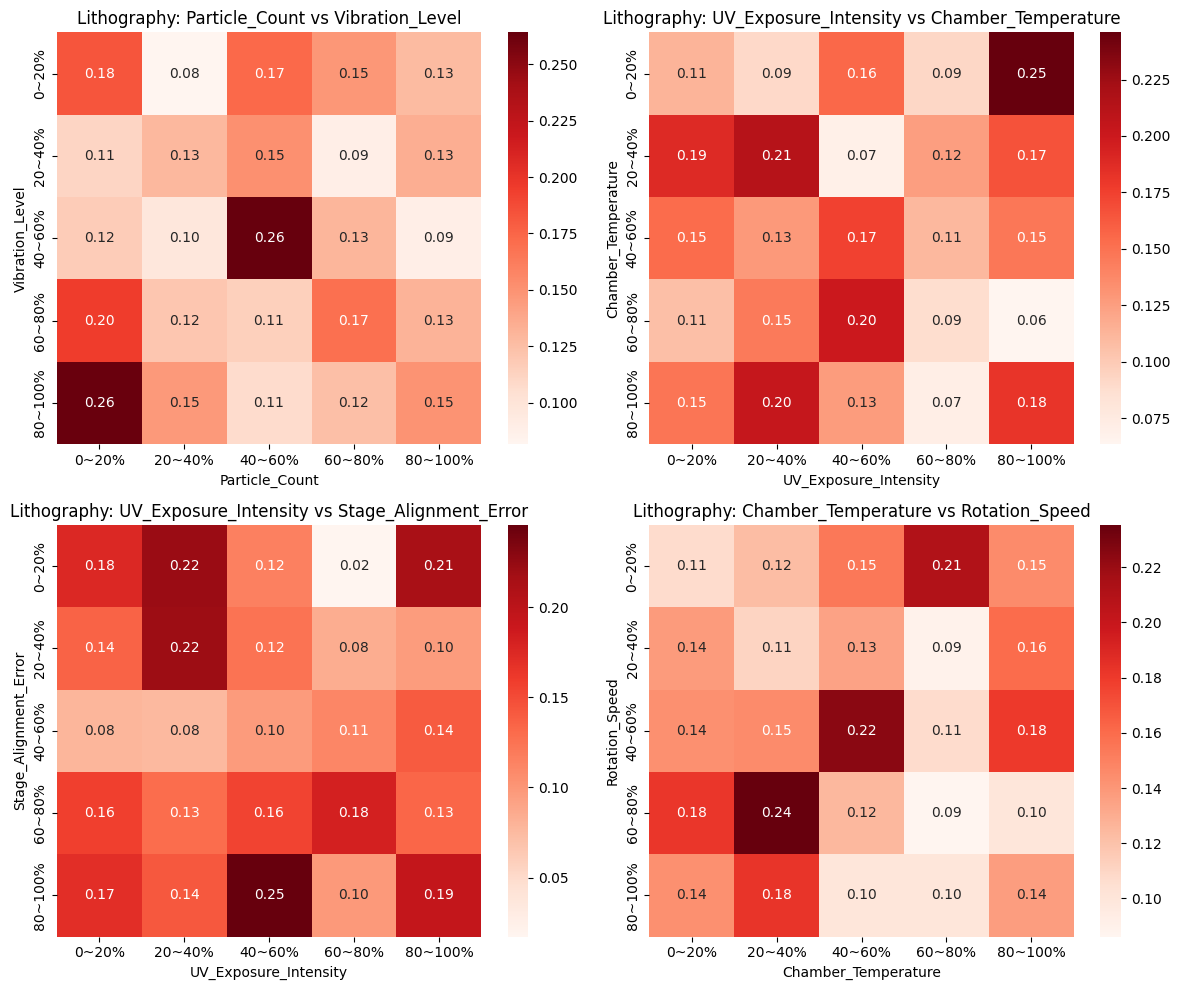

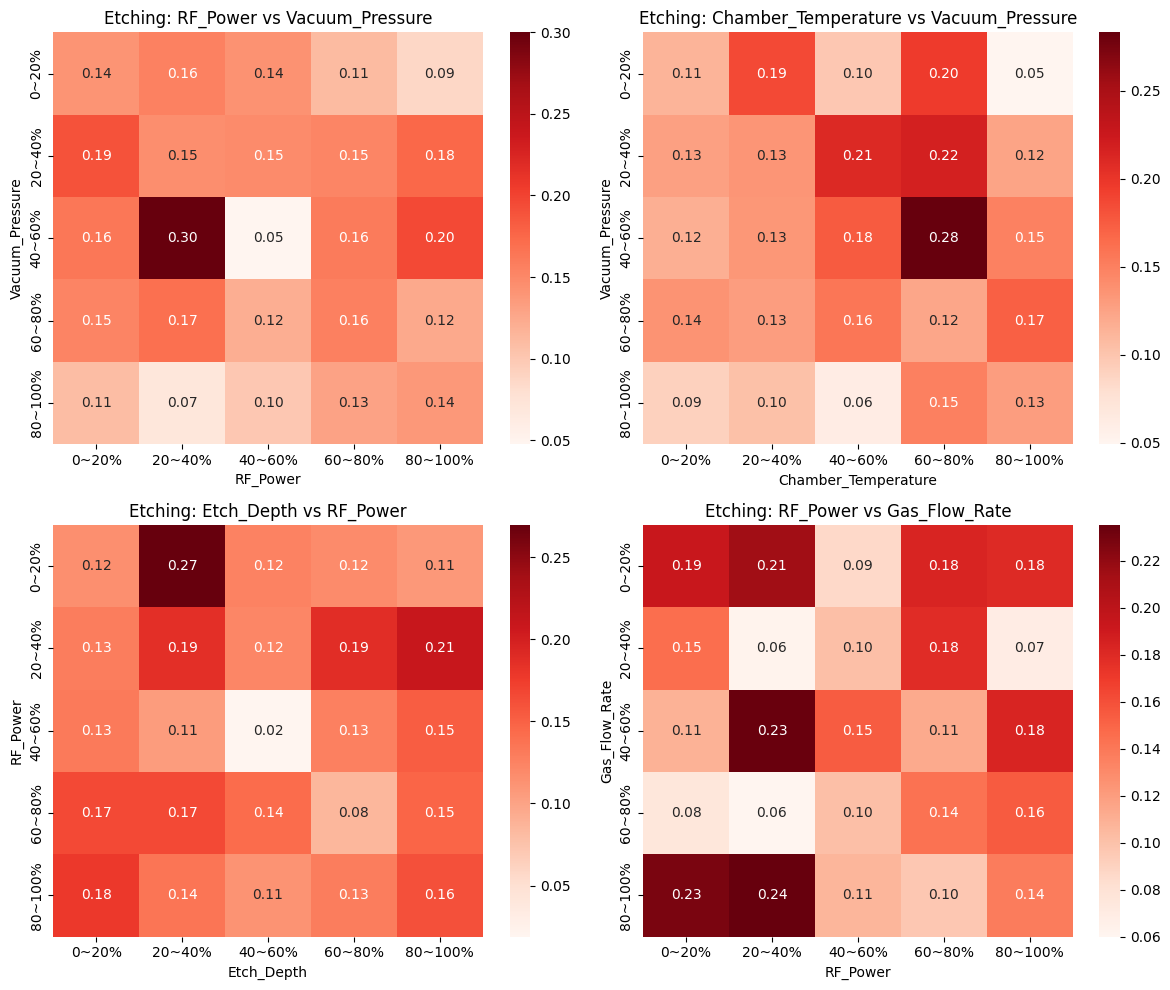

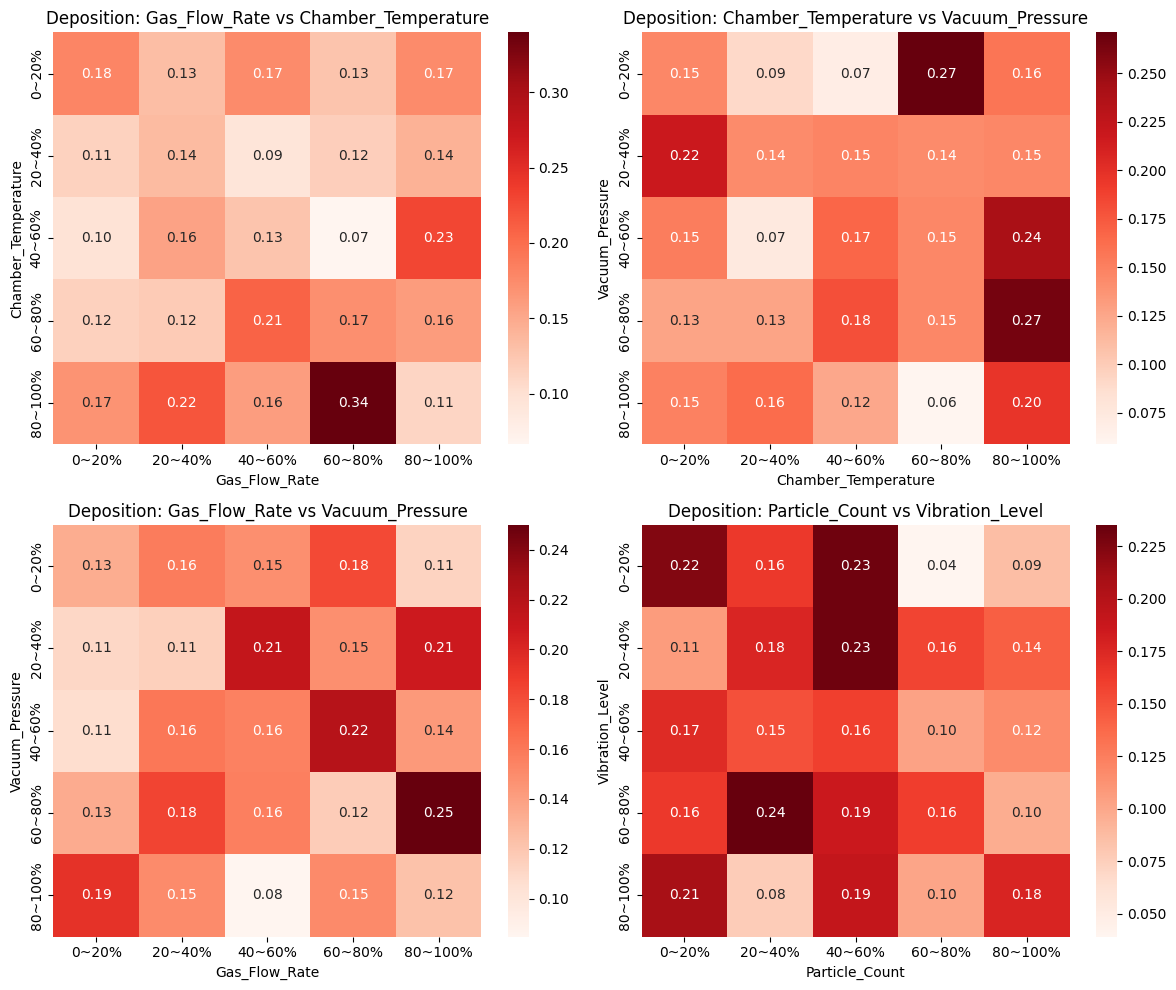

In [52]:
def defect_rate_heatmap_easy(ax, df_in, x, y, target="Defect", bins=5, title="", show_cbar=True):
    df = df_in[[x, y, target]].dropna().copy()

    labels = []
    step = 100 // bins
    for i in range(bins):
        lo = i * step
        hi = (i + 1) * step
        labels.append(f"{lo}~{hi}%")

    df["x_bin"] = pd.qcut(df[x], q=bins, labels=labels, duplicates="drop")
    df["y_bin"] = pd.qcut(df[y], q=bins, labels=labels, duplicates="drop")

    pivot = df.pivot_table(values=target, index="y_bin", columns="x_bin", aggfunc="mean")

    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", ax=ax, cbar=show_cbar)
    ax.set_title(title or f"{x} vs {y}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

def plot_pairs_grid(df_in, pairs, process_name, bins=5, ncols=2):
    n = len(pairs)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*5))
    axes = np.array(axes).reshape(-1)

    for i, (x, y) in enumerate(pairs):
        if x in df_in.columns and y in df_in.columns:
            defect_rate_heatmap_easy(
                axes[i], df_in, x, y, bins=bins,
                title=f"{process_name}: {x} vs {y}",
                show_cbar=True
            )
        else:
            axes[i].axis("off")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# Lithography
df_litho_use = df_litho.copy()
litho_pairs = [
    ("Particle_Count", "Vibration_Level"),
    ("UV_Exposure_Intensity", "Chamber_Temperature"),
    ("UV_Exposure_Intensity", "Stage_Alignment_Error"),
    ("Chamber_Temperature", "Rotation_Speed"),
    
]
plot_pairs_grid(df_litho_use, litho_pairs, "Lithography", bins=5, ncols=2)

# Etching
df_etch_use = df_etch.copy()
etch_pairs = [
    ("RF_Power", "Vacuum_Pressure"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
    ("Etch_Depth", "RF_Power"),
    ("RF_Power", "Gas_Flow_Rate"),
]
plot_pairs_grid(df_etch_use, etch_pairs, "Etching", bins=5, ncols=2)

# Deposition
df_depo_use = df_depo.copy()
depo_pairs = [
    ("Gas_Flow_Rate", "Chamber_Temperature"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
    ("Gas_Flow_Rate", "Vacuum_Pressure"),
    ("Particle_Count", "Vibration_Level"),
]
plot_pairs_grid(df_depo_use, depo_pairs, "Deposition", bins=5, ncols=2)


In [53]:
def rank_triplet_lift(df_in, cols, target="Defect", bins=4, top_n=5, min_count=30):
    base_rate = df_in[target].mean()
    df = df_in[cols + [target]].dropna().copy()

    # 3변수 분위수 binning
    for c in cols:
        df[f"{c}_bin"] = pd.qcut(df[c], q=bins, duplicates="drop")

    grp = df.groupby([f"{cols[0]}_bin", f"{cols[1]}_bin", f"{cols[2]}_bin"])[target]
    rate = grp.mean().reset_index(name="defect_rate")
    cnt  = grp.count().reset_index(name="count")

    merged = rate.merge(cnt, on=[f"{cols[0]}_bin", f"{cols[1]}_bin", f"{cols[2]}_bin"])
    merged["lift"] = merged["defect_rate"] / base_rate

    merged = merged[merged["count"] >= min_count]
    top = merged.sort_values("lift", ascending=False).head(top_n)
    return top


# 공정별 3변수 조합 추천
triplets = {
    "Lithography": (df_litho, ["UV_Exposure_Intensity", "Stage_Alignment_Error", "Chamber_Temperature"]),
    "Etching":     (df_etch,  ["RF_Power", "Vacuum_Pressure", "Gas_Flow_Rate"]),
    "Deposition":  (df_depo,  ["Gas_Flow_Rate", "Chamber_Temperature", "Vacuum_Pressure"]),
}

# 실행
results = {}
for name, (df_proc, cols) in triplets.items():
    results[name] = rank_triplet_lift(df_proc, cols, bins=4, top_n=5, min_count=30)
    print(f"\n=== {name} Top Triplets ===")
    display(results[name])



=== Lithography Top Triplets ===


,UV_Exposure_Intensity_bin,Stage_Alignment_Error_bin,Chamber_Temperature_bin,defect_rate,count,lift
27,"(109.682, 119.711]","(2.001, 2.525]","(78.421, 97.395]",0.142857,35,1.009475



=== Etching Top Triplets ===


,RF_Power_bin,Vacuum_Pressure_bin,Gas_Flow_Rate_bin,defect_rate,count,lift
0,"(128.61599999999999, 265.916]","(0.351, 0.47]","(20.583, 43.484]",0.218750,32,1.528017
24,"(265.916, 301.592]","(0.504, 0.537]","(20.583, 43.484]",0.181818,33,1.270040
53,"(337.429, 476.827]","(0.47, 0.504]","(43.484, 49.848]",0.100000,30,0.698522



=== Deposition Top Triplets ===


,Gas_Flow_Rate_bin,Chamber_Temperature_bin,Vacuum_Pressure_bin,defect_rate,count,lift
13,"(15.465, 42.678]","(78.369, 90.191]","(0.466, 0.498]",0.218750,32,1.420872
3,"(15.465, 42.678]","(58.46, 71.658]","(0.53, 0.688]",0.193548,31,1.257177


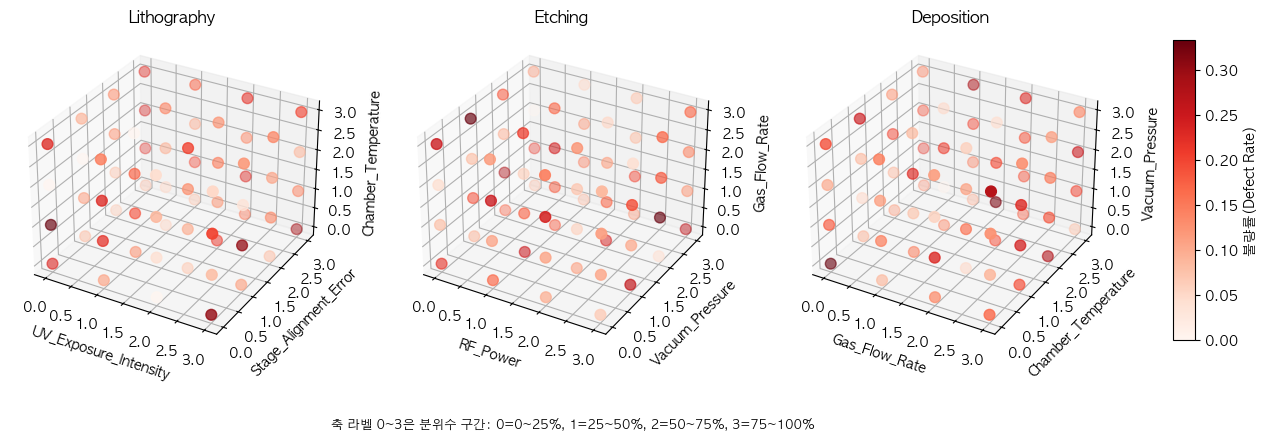

In [81]:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib.pyplot as plt
import matplotlib as mpl


def plot_3d_defect_rate_on_ax(ax, df_in, cols, target="Defect", bins=4, title=""):
    df = df_in[cols + [target]].dropna().copy()
    for c in cols:
        df[f"{c}_bin"] = pd.qcut(df[c], q=bins, labels=False, duplicates="drop")

    grp = df.groupby([f"{cols[0]}_bin", f"{cols[1]}_bin", f"{cols[2]}_bin"])[target]
    rate = grp.mean().reset_index(name="defect_rate")

    x = rate[f"{cols[0]}_bin"]
    y = rate[f"{cols[1]}_bin"]
    z = rate[f"{cols[2]}_bin"]
    c = rate["defect_rate"]

    sc = ax.scatter(x, y, z, c=c, cmap="Reds", s=60)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    ax.set_title(title)
    return sc

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection="3d")
sc1 = plot_3d_defect_rate_on_ax(
    ax1, df_litho,
    ["UV_Exposure_Intensity", "Stage_Alignment_Error", "Chamber_Temperature"],
    bins=4, title="Lithography"
)

ax2 = fig.add_subplot(132, projection="3d")
sc2 = plot_3d_defect_rate_on_ax(
    ax2, df_etch,
    ["RF_Power", "Vacuum_Pressure", "Gas_Flow_Rate"],
    bins=4, title="Etching"
)

ax3 = fig.add_subplot(133, projection="3d")
sc3 = plot_3d_defect_rate_on_ax(
    ax3, df_depo,
    ["Gas_Flow_Rate", "Chamber_Temperature", "Vacuum_Pressure"],
    bins=4, title="Deposition"
)

# 한글 폰트 (macOS 기준)
mpl.rcParams["font.family"] = "AppleGothic"
mpl.rcParams["axes.unicode_minus"] = False

# ----- 기존 3D 서브플롯 코드 실행 후 -----

# 컬러바를 오른쪽으로 이동
fig.subplots_adjust(right=0.86, wspace=0.2)
cax = fig.add_axes([0.900, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
fig.colorbar(sc3, cax=cax, label="불량률(Defect Rate)")

# 설명 박스(한글)
fig.text(
    0.5, 0.02,
    "축 라벨 0~3은 분위수 구간: 0=0~25%, 1=25~50%, 2=50~75%, 3=75~100%",
    ha="center", va="bottom", fontsize=9
)

plt.show()

plt.show()



# 고위험 구간 유의성 검정 코드 설명

## 목적
- 특정 조건(고위험 구간)이 **불량률을 유의하게 증가시키는지** 확인

## 핵심 아이디어
- 전체 데이터를 두 집단으로 나눔  
  1) 고위험 구간(cond=True)  
  2) 나머지 구간(cond=False)
- 두 집단의 **불량률 차이**가 우연인지 아닌지를 z-test로 평가

## 주요 함수
- `norm_cdf(x)`  
  - 표준정규분포 CDF 계산 (scipy 없이 구현)

- `proportions_ztest_no_statsmodels(a, n1, c, n2)`  
  - 두 집단의 불량률 비교 z-test  
  - `p_value`가 작으면(보통 < 0.05) 유의미한 차이

- `significance_test_simple(df_in, cond, target="Defect")`  
  - 고위험/나머지 구간 불량률 계산  
  - lift(배수), p-value, 표본 수 반환

## 출력 결과 해석
- `high_defect_rate` : 고위험 구간 불량률  
- `rest_defect_rate` : 나머지 구간 불량률  
- `lift` : 고위험 구간 불량률이 평균 대비 몇 배인지  
- `p_z` : 유의성 p-value (작을수록 유의)  
- `count_high`, `count_rest` : 각 구간 표본 수

## 현재 조건(cond)
- `Gas_Flow_Rate`가 60~80 분위수 구간
- `Chamber_Temperature`가 상위 20% 구간
- 이 조건이 고위험 구간인지 검정함


In [60]:
import numpy as np
import math

def norm_cdf(x):
    # 표준정규 CDF (scipy 없이)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def proportions_ztest_no_statsmodels(a, n1, c, n2):
    # a/n1 vs c/n2 두 비율 z-test
    p1 = a / n1
    p2 = c / n2
    p_pool = (a + c) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return 0.0, 1.0
    z = (p1 - p2) / se
    # 양측 p-value
    p_value = 2 * (1 - norm_cdf(abs(z)))
    return z, p_value

def significance_test_simple(df_in, cond, target="Defect"):
    a = df_in[cond][target].sum()
    b = df_in[cond].shape[0] - a
    c = df_in[~cond][target].sum()
    d = df_in[~cond].shape[0] - c

    n1 = a + b
    n2 = c + d

    z, p_z = proportions_ztest_no_statsmodels(a, n1, c, n2)

    return {
        "high_defect_rate": a / n1 if n1 > 0 else 0,
        "rest_defect_rate": c / n2 if n2 > 0 else 0,
        "lift": (a / n1) / (c / n2) if n1 > 0 and n2 > 0 else 0,
        "p_z": p_z,
        "count_high": n1,
        "count_rest": n2
    }

g_lo, g_hi = df_depo["Gas_Flow_Rate"].quantile(0.6), df_depo["Gas_Flow_Rate"].quantile(0.8)
t_hi = df_depo["Chamber_Temperature"].quantile(0.8)

cond = (
    df_depo["Gas_Flow_Rate"].between(g_lo, g_hi) &
    (df_depo["Chamber_Temperature"] >= t_hi)
)

result = significance_test_simple(df_depo, cond)
print(result)


{'high_defect_rate': np.float64(0.3333333333333333), 'rest_defect_rate': np.float64(0.14684287812041116), 'lift': np.float64(2.27), 'p_z': 0.00019604200857159526, 'count_high': np.int64(54), 'count_rest': np.int64(1362)}


# 히트맵 기반 Top N 고위험 구간 룰 생성 코드 설명

## 목적
- 2D 히트맵에서 **불량률이 가장 높은 구간(Top N)**을 자동 추출
- 해당 구간을 **룰 기반 피처(0/1)**로 만들어 모델 학습에 활용

## 동작 원리
1. 변수 2개(`x`, `y`)를 분위수(quantile) 기준으로 binning  
2. 각 bin 조합에서 불량률(Defect rate) 계산  
3. 불량률이 높은 Top N 구간을 선택  
4. 선택된 구간에 해당하는 샘플이면 `1`, 아니면 `0`으로 룰 컬럼 생성  

## 코드 구성
- `make_topN_rules(df_in, x, y, ...)`
  - `x`, `y` 변수로 히트맵 구간 생성
  - 불량률 상위 Top N 셀을 찾음
  - 각 셀을 룰 컬럼으로 추가

- 공정별 변수쌍 리스트
  - **Lithography / Etching / Deposition**에 대해
  - 추천 변수쌍으로 자동 실행
  - 결과로 `litho_*`, `etch_*`, `depo_*` 룰 컬럼 생성

## 결과
- 각 공정 데이터프레임에 **고위험 구간 룰 컬럼**이 추가됨  
- 모델 입력에 포함하면 고위험 조건을 학습할 수 있음  

## 활용
- 룰 컬럼을 모델 입력에 추가
- 성능 개선 여부(PR-AUC, Recall 등) 비교
- 유의미한 룰만 남겨 해석/운영 기준으로 활용


In [47]:
def make_topN_rules(df_in, x, y, target="Defect", bins=5, top_n=3, prefix="rule"):
    df = df_in[[x, y, target]].dropna().copy()

    df["x_bin"] = pd.qcut(df[x], q=bins, duplicates="drop")
    df["y_bin"] = pd.qcut(df[y], q=bins, duplicates="drop")

    pivot = df.pivot_table(values=target, index="y_bin", columns="x_bin", aggfunc="mean")

    top_cells = (
        pivot.stack()
        .reset_index()
        .sort_values(by=0, ascending=False)
        .head(top_n)
    )
    top_cells.columns = ["y_bin", "x_bin", "defect_rate"]

    # 룰 컬럼 생성
    for i, row in top_cells.iterrows():
        x_bin = row["x_bin"]
        y_bin = row["y_bin"]
        rule_name = f"{prefix}_{i+1}_{x}_{y}"
        df_in[rule_name] = (
            (df_in[x].between(x_bin.left, x_bin.right, inclusive="right")) &
            (df_in[y].between(y_bin.left, y_bin.right, inclusive="right"))
        ).astype(int)

    return df_in, top_cells


# 공정별 변수쌍
litho_pairs = [
    ("UV_Exposure_Intensity", "Stage_Alignment_Error"),
    ("Chamber_Temperature", "Rotation_Speed"),
    ("Particle_Count", "Vibration_Level"),
    ("UV_Exposure_Intensity", "Chamber_Temperature"),
]

etch_pairs = [
    ("RF_Power", "Vacuum_Pressure"),
    ("RF_Power", "Gas_Flow_Rate"),
    ("Etch_Depth", "RF_Power"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
]

depo_pairs = [
    ("Gas_Flow_Rate", "Chamber_Temperature"),
    ("Gas_Flow_Rate", "Vacuum_Pressure"),
    ("Chamber_Temperature", "Vacuum_Pressure"),
    ("Particle_Count", "Vibration_Level"),
]

# 공정별 적용
for x, y in litho_pairs:
    if x in df_litho.columns and y in df_litho.columns:
        df_litho, top_cells = make_topN_rules(df_litho, x, y, top_n=3, prefix="litho")

for x, y in etch_pairs:
    if x in df_etch.columns and y in df_etch.columns:
        df_etch, top_cells = make_topN_rules(df_etch, x, y, top_n=3, prefix="etch")

for x, y in depo_pairs:
    if x in df_depo.columns and y in df_depo.columns:
        df_depo, top_cells = make_topN_rules(df_depo, x, y, top_n=3, prefix="depo")
        
display(df_litho.head())
display(df_etch.head())
display(df_depo.head())  

,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,...,litho_7_UV_Exposure_Intensity_Stage_Alignment_Error,litho_17_Chamber_Temperature_Rotation_Speed,litho_13_Chamber_Temperature_Rotation_Speed,litho_4_Chamber_Temperature_Rotation_Speed,litho_13_Particle_Count_Vibration_Level,litho_21_Particle_Count_Vibration_Level,litho_16_Particle_Count_Vibration_Level,litho_5_UV_Exposure_Intensity_Chamber_Temperature,litho_7_UV_Exposure_Intensity_Chamber_Temperature,litho_22_UV_Exposure_Intensity_Chamber_Temperature
0,lithography,WAF58120,74.077728,56.527432,324.281923,554.358076,1397.936121,0.549974,2.147302,0.009007,...,0,0,0,0,0,0,0,0,0,0
4,lithography,WAF39030,76.221205,59.152873,289.702098,458.012763,1785.025252,0.557101,2.338089,0.009590,...,0,0,0,0,1,0,0,0,0,0
5,lithography,WAF77484,72.406000,52.230743,286.161543,495.476249,1363.693532,0.432724,3.133414,0.009360,...,0,0,0,0,1,0,0,0,0,0
10,lithography,WAF89845,74.777007,46.819801,279.926539,563.066838,2071.380657,0.392305,0.197213,0.011887,...,0,0,0,0,0,0,0,0,0,0
11,lithography,WAF49453,85.666323,69.293533,285.921599,511.264062,1360.282764,0.529752,2.423294,0.018540,...,0,0,0,0,0,0,0,0,0,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,...,etch_6_RF_Power_Vacuum_Pressure,etch_22_RF_Power_Gas_Flow_Rate,etch_12_RF_Power_Gas_Flow_Rate,etch_21_RF_Power_Gas_Flow_Rate,etch_2_Etch_Depth_RF_Power,etch_10_Etch_Depth_RF_Power,etch_9_Etch_Depth_RF_Power,etch_14_Chamber_Temperature_Vacuum_Pressure,etch_9_Chamber_Temperature_Vacuum_Pressure,etch_8_Chamber_Temperature_Vacuum_Pressure
3,etching,WAF46726,79.467364,47.569284,301.464082,488.986118,1342.928970,0.492940,1.564590,0.009416,...,0,0,0,0,0,0,0,1,0,0
6,etching,WAF93190,74.031582,34.524690,325.060209,502.503207,1860.943159,0.557813,1.858771,0.008604,...,0,0,0,0,0,0,0,0,0,0
8,etching,WAF90138,75.574564,31.129065,222.565983,485.660598,1037.924539,0.494761,2.842610,0.015432,...,0,0,0,0,0,0,0,0,0,0
9,etching,WAF34798,89.370413,74.383993,221.146587,618.681459,1342.417979,0.446146,1.823190,0.015130,...,0,0,0,1,0,0,0,0,0,0
12,etching,WAF54023,69.662915,50.122469,271.631064,403.201004,1383.952796,0.438330,1.827425,0.003506,...,0,0,1,0,0,0,0,0,0,0


,Tool_Type,Wafer_ID,Chamber_Temperature,Gas_Flow_Rate,RF_Power,Etch_Depth,Rotation_Speed,Vacuum_Pressure,Stage_Alignment_Error,Vibration_Level,...,depo_22_Gas_Flow_Rate_Chamber_Temperature,depo_20_Gas_Flow_Rate_Vacuum_Pressure,depo_14_Gas_Flow_Rate_Vacuum_Pressure,depo_8_Gas_Flow_Rate_Vacuum_Pressure,depo_4_Chamber_Temperature_Vacuum_Pressure,depo_20_Chamber_Temperature_Vacuum_Pressure,depo_15_Chamber_Temperature_Vacuum_Pressure,depo_17_Particle_Count_Vibration_Level,depo_3_Particle_Count_Vibration_Level,depo_8_Particle_Count_Vibration_Level
1,deposition,WAF31094,74.341499,39.350802,364.527083,493.382895,1433.488274,0.407351,2.970405,0.007927,...,0,0,0,0,0,0,0,0,0,1
2,deposition,WAF44062,74.626094,38.181393,314.257182,589.544476,1311.345430,0.480282,1.310555,0.008856,...,0,0,0,0,0,0,0,0,0,0
7,deposition,WAF48082,74.972943,34.676196,219.520268,564.177109,1250.188972,0.570861,0.037162,0.009037,...,0,0,0,0,0,0,0,0,0,0
23,deposition,WAF66820,69.510619,57.636426,315.717919,611.399196,1152.332112,0.514648,2.254649,0.001079,...,0,0,0,0,0,0,0,0,0,0
24,deposition,WAF90800,76.939137,44.227121,355.982551,505.679897,1359.628708,0.477417,2.752692,0.019110,...,0,0,0,0,0,0,0,0,0,0


# 3D 히트맵 기반 결함 확률 높은 변수 추가 툴

# 고위험 구간 유의성 검정 코드 설명

## 목적
- 특정 조건(고위험 구간)이 **불량률을 유의하게 증가시키는지** 확인

## 핵심 아이디어
- 전체 데이터를 두 집단으로 나눔  
  1) 고위험 구간(cond=True)  
  2) 나머지 구간(cond=False)
- 두 집단의 **불량률 차이**가 우연인지 아닌지를 z-test로 평가

## 주요 함수
- `norm_cdf(x)`  
  - 표준정규분포 CDF 계산 (scipy 없이 구현)

- `proportions_ztest_no_statsmodels(a, n1, c, n2)`  
  - 두 집단의 불량률 비교 z-test  
  - `p_value`가 작으면(보통 < 0.05) 유의미한 차이

- `significance_test_simple(df_in, cond, target="Defect")`  
  - 고위험/나머지 구간 불량률 계산  
  - lift(배수), p-value, 표본 수 반환

## 출력 결과 해석
- `high_defect_rate` : 고위험 구간 불량률  
- `rest_defect_rate` : 나머지 구간 불량률  
- `lift` : 고위험 구간 불량률이 평균 대비 몇 배인지  
- `p_z` : 유의성 p-value (작을수록 유의)  
- `count_high`, `count_rest` : 각 구간 표본 수

## 현재 조건(cond)
- `Gas_Flow_Rate`가 60~80 분위수 구간
- `Chamber_Temperature`가 상위 20% 구간
- 이 조건이 고위험 구간인지 검정함


In [48]:
from sklearn.model_selection import GroupShuffleSplit

# 1) 룰 컬럼 포함 데이터로 GroupSplit 다시 수행
def group_split_wafer(df_in, name=""):
    if "Wafer_ID" not in df_in.columns:
        raise KeyError(f"[{name}] Wafer_ID 없음")

    X = df_in.drop(columns=["Defect"])
    y = df_in["Defect"]
    groups = df_in["Wafer_ID"]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train = X.iloc[train_idx].copy()
    X_test  = X.iloc[test_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_test  = y.iloc[test_idx].copy()

    # 분할 후 Wafer_ID 제거
    X_train = X_train.drop(columns=["Wafer_ID"])
    X_test  = X_test.drop(columns=["Wafer_ID"])

    print(f"[{name}] group overlap:", len(set(groups.iloc[train_idx]).intersection(set(groups.iloc[test_idx]))))
    return X_train, X_test, y_train, y_test

Xl_tr2, Xl_te2, yl_tr2, yl_te2 = group_split_wafer(df_litho, "Lithography")
Xe_tr2, Xe_te2, ye_tr2, ye_te2 = group_split_wafer(df_etch, "Etching")
Xd_tr2, Xd_te2, yd_tr2, yd_te2 = group_split_wafer(df_depo, "Deposition")


# 2) 기존 eval_models로 평가 (룰 컬럼 포함)
all_results = []
all_results += eval_models(Xl_tr2, Xl_te2, yl_tr2, yl_te2, "Lithography")
all_results += eval_models(Xe_tr2, Xe_te2, ye_tr2, ye_te2, "Etching")
all_results += eval_models(Xd_tr2, Xd_te2, yd_tr2, yd_te2, "Deposition")

result_df = pd.DataFrame(all_results).sort_values(
    ["Process", "PR_AUC"], ascending=[True, False]
)
display(result_df)


[Lithography] group overlap: 0
[Etching] group overlap: 0
[Deposition] group overlap: 0
[LightGBM] [Info] Number of positive: 158, number of negative: 949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1107, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 174, number of negative: 961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data p

,Process,Model,PR_AUC,Recall
6,Deposition,LogisticRegression,0.221247,0.487179
7,Deposition,RandomForest,0.195345,0.000000
8,Deposition,LightGBM,0.169471,0.051282
3,Etching,LogisticRegression,0.170475,0.551724
5,Etching,LightGBM,0.150386,0.068966
4,Etching,RandomForest,0.132239,0.000000
2,Lithography,LightGBM,0.171822,0.052632
1,Lithography,RandomForest,0.165429,0.000000
0,Lithography,LogisticRegression,0.158910,0.368421


# 공정별 베이스라인 모델 비교

## 목적
- 공정별로 **로지스틱 / 랜덤포레스트 / LightGBM** 3가지 모델을 빠르게 비교
- **PR-AUC**와 **Recall** 중심으로 성능을 평가

## 평가 지표
- **PR-AUC**: 클래스 불균형 상황에서 유용한 성능 지표  
- **Recall**: 불량(Defect)을 얼마나 놓치지 않고 잡는지 확인

## 모델 구성
1. **Logistic Regression**
   - 표준화(`StandardScaler`) 포함
   - `class_weight="balanced"`로 불균형 대응
2. **Random Forest**
   - 비선형 패턴 대응
   - `class_weight="balanced"`
3. **LightGBM**
   - 성능 개선 가능성 높은 모델
   - 라이브러리 미설치 시 자동 스킵

## 실행 흐름
1. 공정별 train/test 데이터로 모델 학습  
2. 예측 확률 → PR-AUC 계산  
3. 0.5 기준 예측값 → Recall 계산  
4. 공정별 결과 테이블로 비교

## 결과
- 공정별 PR-AUC/Recall이 높은 모델을 1차 후보로 선정  
- 성능이 부족한 공정은 이후 **AutoML 또는 튜닝** 단계로 진행


In [34]:
def eval_models(X_train, X_test, y_train, y_test, name=""):
    results = []

    # 수치형 컬럼만 사용
    X_train = X_train.select_dtypes(include=[np.number])
    X_test  = X_test.select_dtypes(include=[np.number])

    # 1) Logistic Regression (표준화 포함)
    lr = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])
    lr.fit(X_train, y_train)
    lr_proba = lr.predict_proba(X_test)[:, 1]
    lr_pred = (lr_proba >= 0.5).astype(int)
    results.append({
        "Process": name,
        "Model": "LogisticRegression",
        "PR_AUC": average_precision_score(y_test, lr_proba),
        "Recall": recall_score(y_test, lr_pred)
    })

    # 2) Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_proba = rf.predict_proba(X_test)[:, 1]
    rf_pred = (rf_proba >= 0.5).astype(int)
    results.append({
        "Process": name,
        "Model": "RandomForest",
        "PR_AUC": average_precision_score(y_test, rf_proba),
        "Recall": recall_score(y_test, rf_pred)
    })

    # 3) LightGBM
    if HAS_LGBM:
        lgbm = LGBMClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        )
        lgbm.fit(X_train, y_train)
        lgbm_proba = lgbm.predict_proba(X_test)[:, 1]
        lgbm_pred = (lgbm_proba >= 0.5).astype(int)
        results.append({
            "Process": name,
            "Model": "LightGBM",
            "PR_AUC": average_precision_score(y_test, lgbm_proba),
            "Recall": recall_score(y_test, lgbm_pred)
        })
    else:
        print(f"[{name}] LightGBM 미설치 → 스킵")

    return results

    
# LightGBM 설치 여부 체크 (셀 맨 위에 두고 1회만 실행)
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False




# 공정별 실행
all_results = []
all_results += eval_models(Xl_tr, Xl_te, yl_tr, yl_te, "Lithography")
all_results += eval_models(Xe_tr, Xe_te, ye_tr, ye_te, "Etching")
all_results += eval_models(Xd_tr, Xd_te, yd_tr, yd_te, "Deposition")

# 결과 정리
result_df = pd.DataFrame(all_results).sort_values(
    ["Process", "PR_AUC"], ascending=[True, False]
)

display(result_df)


[LightGBM] [Info] Number of positive: 158, number of negative: 949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1107, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 174, number of negative: 961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1135, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

,Process,Model,PR_AUC,Recall
7,Deposition,RandomForest,0.193040,0.000000
8,Deposition,LightGBM,0.172263,0.051282
6,Deposition,LogisticRegression,0.157288,0.512821
5,Etching,LightGBM,0.139557,0.068966
4,Etching,RandomForest,0.124520,0.000000
3,Etching,LogisticRegression,0.113233,0.655172
2,Lithography,LightGBM,0.181978,0.052632
1,Lithography,RandomForest,0.155355,0.000000
0,Lithography,LogisticRegression,0.118060,0.500000


In [35]:
all_results = []
all_results += eval_models(Xl_tr_fe, Xl_te_fe, yl_tr, yl_te, "Lithography")
all_results += eval_models(Xe_tr_fe, Xe_te_fe, ye_tr, ye_te, "Etching")
all_results += eval_models(Xd_tr_fe, Xd_te_fe, yd_tr, yd_te, "Deposition")

result_df = pd.DataFrame(all_results).sort_values(
    ["Process", "PR_AUC"], ascending=[True, False]
)
display(result_df)


[LightGBM] [Info] Number of positive: 158, number of negative: 949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1107, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 174, number of negative: 961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1135, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

,Process,Model,PR_AUC,Recall
7,Deposition,RandomForest,0.191270,0.000000
8,Deposition,LightGBM,0.170797,0.051282
6,Deposition,LogisticRegression,0.158869,0.512821
5,Etching,LightGBM,0.150637,0.068966
4,Etching,RandomForest,0.128100,0.000000
3,Etching,LogisticRegression,0.113442,0.655172
2,Lithography,LightGBM,0.172300,0.052632
1,Lithography,RandomForest,0.146226,0.000000
0,Lithography,LogisticRegression,0.116420,0.500000


[LightGBM] [Info] Number of positive: 158, number of negative: 949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 1107, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[Lithography] PR-AUC: 0.1820
[Lithography] Best Threshold (F1): 0.0000
[Lithography] Precision/Recall at Best Thr: 0.1377 / 1.0000


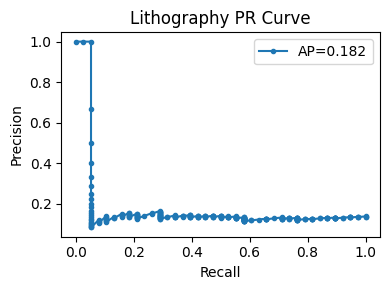

[LightGBM] [Info] Number of positive: 174, number of negative: 961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 1135, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[Etching] PR-AUC: 0.1396
[Etching] Best Threshold (F1): 0.0027
[Etching] Precision/Recall at Best Thr: 0.1440 / 0.6207


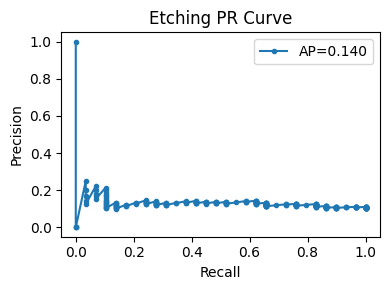

[Deposition] PR-AUC: 0.1930
[Deposition] Best Threshold (F1): 0.1000
[Deposition] Precision/Recall at Best Thr: 0.1447 / 0.8462


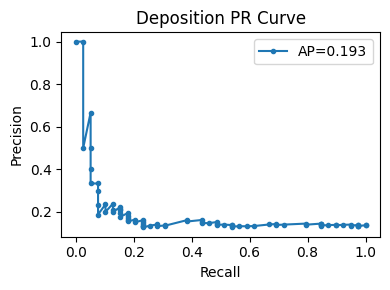

In [21]:
def train_and_prcurve(X_train, X_test, y_train, y_test, name, model):
    # 수치형만 사용
    X_train = X_train.select_dtypes(include=[np.number])
    X_test  = X_test.select_dtypes(include=[np.number])

    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    # PR-AUC
    ap = average_precision_score(y_test, proba)

    # PR-커브
    precision, recall, thresholds = precision_recall_curve(y_test, proba)

    # F1 기준 최적 임계값
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.nanargmax(f1)
    best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    print(f"[{name}] PR-AUC: {ap:.4f}")
    print(f"[{name}] Best Threshold (F1): {best_thr:.4f}")
    print(f"[{name}] Precision/Recall at Best Thr: {precision[best_idx]:.4f} / {recall[best_idx]:.4f}")

    # Plot
    plt.figure(figsize=(4, 3))
    plt.plot(recall, precision, marker=".", label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} PR Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_thr

# 공정별 모델 지정
from sklearn.ensemble import RandomForestClassifier
# LightGBM은 설치되어 있어야 함
from lightgbm import LGBMClassifier

# Lithography: LightGBM
best_thr_litho = train_and_prcurve(
    Xl_tr, Xl_te, yl_tr, yl_te,
    "Lithography", LGBMClassifier(n_estimators=300, random_state=42, class_weight="balanced")
)

# Etching: LightGBM
best_thr_etch = train_and_prcurve(
    Xe_tr, Xe_te, ye_tr, ye_te,
    "Etching", LGBMClassifier(n_estimators=300, random_state=42, class_weight="balanced")
)

# Deposition: RandomForest
best_thr_depo = train_and_prcurve(
    Xd_tr, Xd_te, yd_tr, yd_te,
    "Deposition", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1)
)
